# Climate Change Perception

This project explores the impact of multiple variables on a population's percpetion of climate change threat. It uses the following publicly available data sources, all split by country:
1. Climate change perception (Gapminder)
2. Deaths caused by natural disasters, excluding epidemics (Gapminder)
3. Mean years of schooling (United Nations)
4. Oil production (Gapminder)
5. World press freedom index (Reporters without Borders)

The code below includes:
1. Library Import
2. Data Import and Preprocessing
3. Data Merging and Cleaning
4. Exploratory Data Analysis
5. Regression Model Development
6. Model Evaluation
7. Geographic Visualization

### Library Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score

### Data Import and Preprocessing

Import the datasets

In [2]:
perception = pd.read_csv('../Projects/Cleaned Data/CC Perception.csv')
disasters = pd.read_csv('../Projects/Cleaned Data/Disaster Deaths.csv')
education = pd.read_csv('../Projects/Cleaned Data/Education.csv')
oil = pd.read_csv('../Projects/Cleaned Data/Oil Production.csv')
media = pd.read_csv('../Projects/Cleaned Data/Press Freedom.csv')

Clean the data:
* Remove unnecessary columns
* Rename columns to create a common key
* Number formatting
* Aggregate & group data (for natural diaster data - sum all deaths from 2011-2021)
* Fix case for key

In [3]:
perception = perception.drop(columns=['Year'])
perception = perception.rename(columns={'Overall is threat': 'Overall threat perception'})
perception['Very serious threat'] = perception['Very serious threat'].str.rstrip('%').astype('float')
perception['Somewhat serious threat '] = perception['Somewhat serious threat '].str.rstrip('%').astype('float')
perception['Overall threat perception'] = perception['Overall threat perception'].str.rstrip('%').astype('float')

In [4]:
disasters = disasters[disasters['Year'] >= 2011]
disasters = disasters.drop(columns=['name','Year','Number of natural disaster deaths'])
disasters = disasters.groupby('geo').agg('sum')

In [5]:
education = education.drop(columns=['Country'])
education = education.rename(columns={'Country code': 'geo'})
education['geo']=education['geo'].str.lower()

In [6]:
oil = oil.drop(columns=['country'])
oil = oil.rename(columns={'code': 'geo', '2019 production': 'Oil Production'})
oil['geo']= oil['geo'].str.lower()

In [7]:
media = media.rename(columns={'Code': 'geo', 'Score': 'Press Freedom'})
media['geo']= media['geo'].str.lower()

### Data Merging and Cleaning

Merge the data sources into one dataframe and complete the following preprocessing steps:
* Remove rows with missing climate change threat perception scores
* Create a calculated column for the number of natural disaster deaths per 100K population
* Remove unneeded columns
* Fill in nulls with appropriate values

In [8]:
df = pd.merge(perception,disasters,on='geo',how='outer')
df = pd.merge(df,education,on='geo',how='outer')
df = pd.merge(df,oil,on='geo',how='outer')
df = pd.merge(df,media,on='geo',how='outer')


df = df.dropna(subset=['Overall threat perception'])
df['Disaster Deaths per 100K People'] = df['Number of natural disaster deaths, excluding epidemics '] / df['Population'] * 100000
df = df.drop(columns=['Number of natural disaster deaths, excluding epidemics '])
df['Oil Production'] = df['Oil Production'].fillna(0)
df['MYS'] = df['MYS'].fillna(df['MYS'].median())
df['Disaster Deaths per 100K People'] = df['Disaster Deaths per 100K People'].fillna(df['Disaster Deaths per 100K People'].median())

### Exploratory Data Analysis

This section explores the relationship between each of the independent variables (years of education, oil production, press freedom, and natural diaster deaths) on the dependent variable (% of population who believe climate change is a threat).

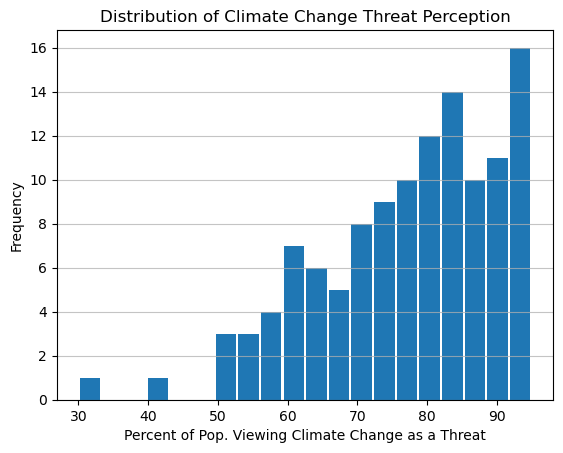

In [9]:
df['Overall threat perception'].plot.hist(bins=20, rwidth=0.9)
plt.title('Distribution of Climate Change Threat Perception')
plt.xlabel('Percent of Pop. Viewing Climate Change as a Threat')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

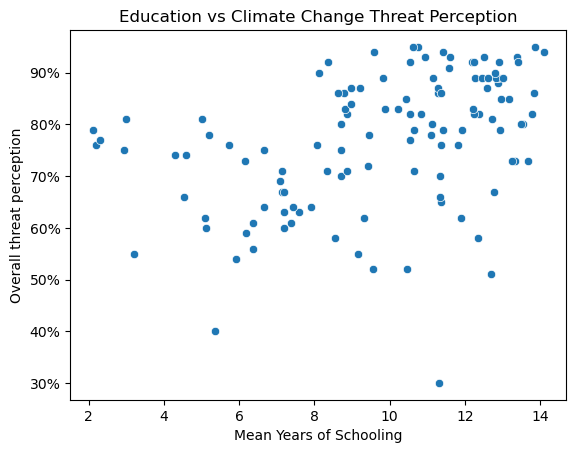

In [10]:
plot = sns.scatterplot(x='MYS', y='Overall threat perception', data=df)
plt.xlabel('Mean Years of Schooling')
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Education vs Climate Change Threat Perception", loc='center', size=12);

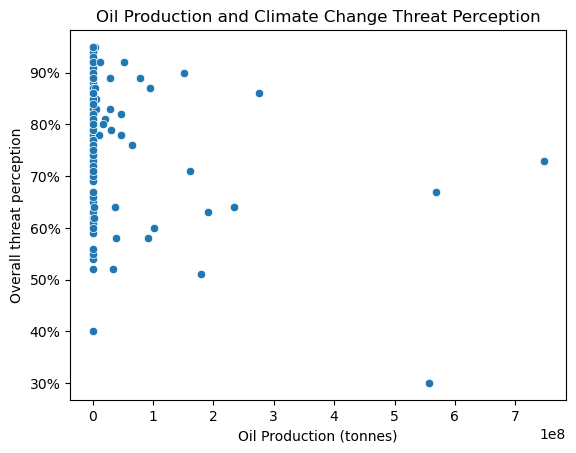

In [11]:
plot = sns.scatterplot(x='Oil Production', y='Overall threat perception', data=df)
plt.xlabel('Oil Production (tonnes)')
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Oil Production and Climate Change Threat Perception", loc='center', size=12);

Oil production and climate change perception clearly do not have a linear relationship. Instead, create a categorical variable depending on whether a country produces no oil, some oil, or a high volume of oil, and assess the distribution of climate change threat perception based on those categories.

c:\Users\SarahEshafi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


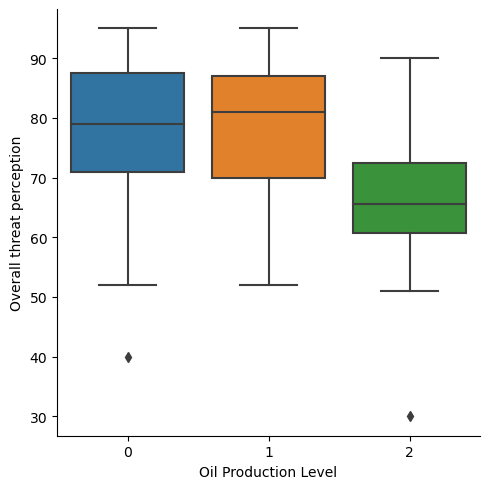

In [12]:
df['Oil Production Level'] = df['Oil Production'].apply(lambda x: 0 if x == 0 else 1 if x < 100000000 else 2)
plot = sns.catplot(data=df, x="Oil Production Level", y="Overall threat perception", kind="box");

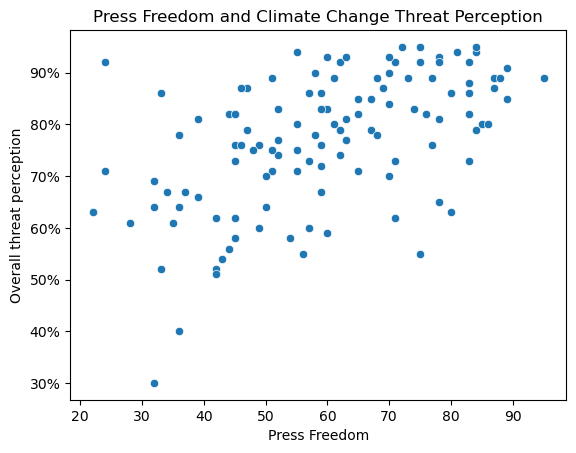

In [13]:
plot = sns.scatterplot(x='Press Freedom', y='Overall threat perception', data=df)
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Press Freedom and Climate Change Threat Perception", loc='center', size=12);

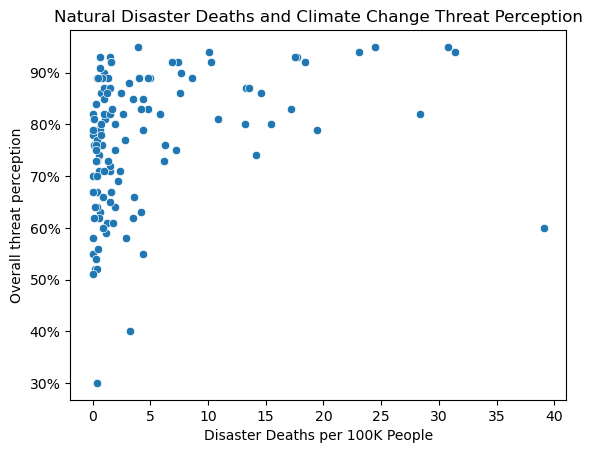

In [14]:
plot = sns.scatterplot(x=df['Disaster Deaths per 100K People'], y='Overall threat perception', data=df)
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Natural Disaster Deaths and Climate Change Threat Perception", loc='center', size=12);

From the above, it is clear natural disaster death rate and climate change threat perception do not have a linear relationship. Try taking the log of natural disaster deaths to make it linear.

c:\Users\SarahEshafi\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


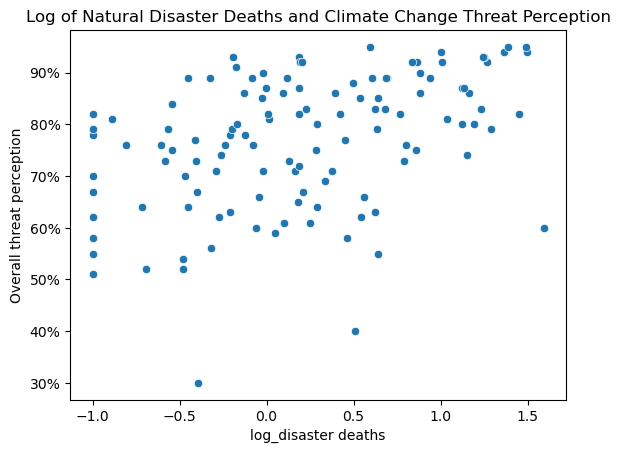

In [15]:
df['log_disaster deaths'] = np.log10(df['Disaster Deaths per 100K People'])
df['log_disaster deaths'] = df['Disaster Deaths per 100K People'].apply(lambda x: -1 if x < 0.1 else np.log10(x))

plot = sns.scatterplot(x=df['log_disaster deaths'], y='Overall threat perception', data=df)
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Log of Natural Disaster Deaths and Climate Change Threat Perception", loc='center', size=12);

Finally, create a correlation matrix to get a sense of the relationship between all variables.

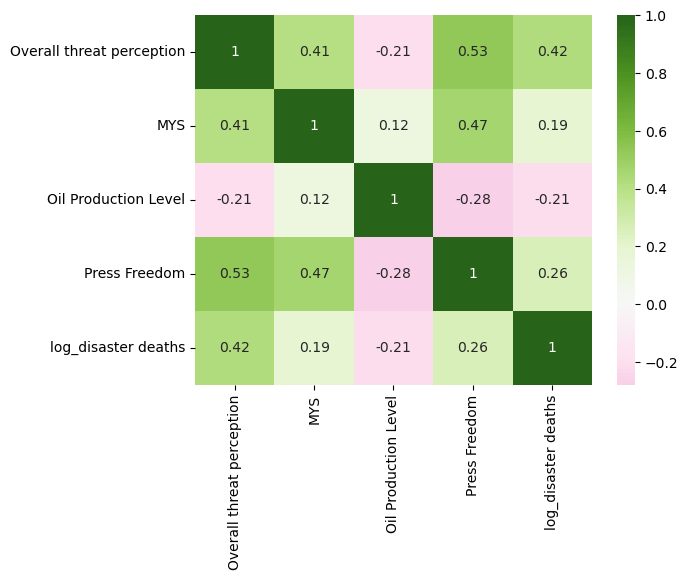

In [16]:
df_trimmed = df[['Overall threat perception', 'MYS', 'Oil Production Level', 'Press Freedom', 'log_disaster deaths']]
corr_matrix = df_trimmed.corr()
sns.heatmap(corr_matrix, annot=True, center=0, cmap="PiYG")
plt.show()

### Regression Model Development

Use SciKitLearn to create a multiple linear regression model

In [17]:
Y = df['Overall threat perception']
X = df[['MYS', 'Oil Production Level', 'Press Freedom', 'log_disaster deaths']]
reg = linear_model.LinearRegression()
reg.fit(X, Y);

In [18]:
reg.coef_

array([ 0.88569391, -1.61328471,  0.25337744,  5.21784664])

### Model Evaluation

Evaluate the model by getting the R-squared value, plotting the predicted vs actual threat perception to visually evaluate if the residuals are variable, and create a histogram of the residuals to ensure they are normally distributed.

In [19]:
y_pred = reg.predict(X)
r2_score(Y, y_pred)

0.39956623368661237

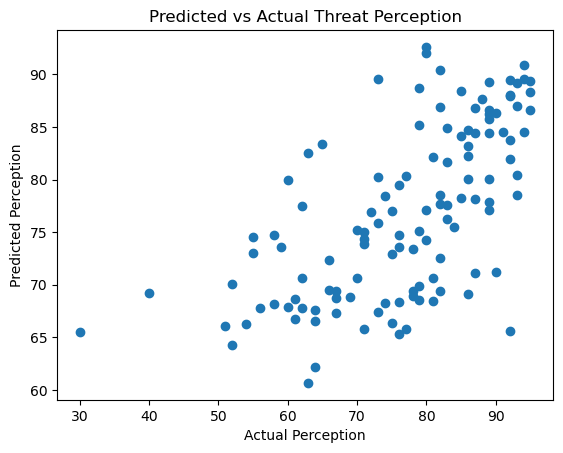

In [20]:
plot = plt.scatter(Y, y_pred)
plt.xlabel('Actual Perception')
plt.ylabel('Predicted Perception')
plt.title("Predicted vs Actual Threat Perception", loc='center', size=12);

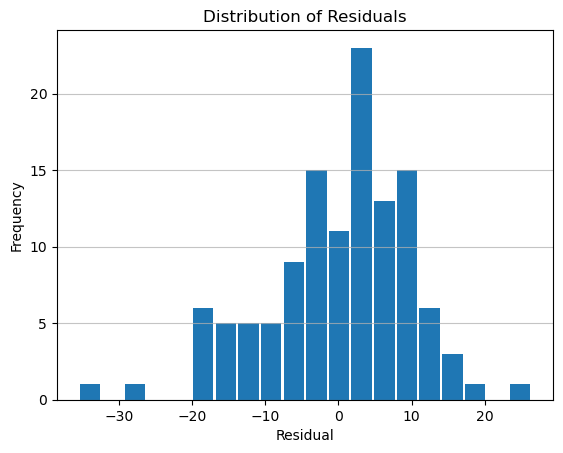

In [24]:
residuals = Y - y_pred
residuals.plot.hist(bins=20, rwidth=0.9)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)


Overall, the model does a moderate job of explaining the dependent variable, with an R-squared value of 0.40. Climate change perception is a highly complex topic that can be difficult to predict. Going forward, one may test additional variables and further scruitenize the chosen variables in this project.

### Geographic Visualization

In [26]:
import plotly.express as px

df['geo'] = df['geo'].str.upper()
fig = px.choropleth(df, locations='geo', color='Overall threat perception', color_continuous_scale="RdYlGn", hover_name='name',
                    labels = {'Overall threat perception': '%'},projection='natural earth', title='Percentage of Population Viewing Climate Change as a Threat')
fig.show()
fig.write_html("../Projects/Cleaned Data/map.html")